In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.regularizers import l2

In [36]:
# Load all the processed datasets
file_paths = {
"medications": "ProcessedData/processed_medications.csv",
"observations": "ProcessedData/processed_observations.csv",
"patients": "ProcessedData/processed_patients.csv",
"allergies": "ProcessedData/processed_allergies.csv",
"conditions": "ProcessedData/processed_conditions.csv",
"immunizations": "ProcessedData/processed_immunizations.csv",
}

In [42]:

def load_and_merge_data(file_paths):
    # Read and standardize identifier columns to "id"
    data_frames = {}
    for key, path in file_paths.items():
        df = pd.read_csv(path)
        id_columns = [col for col in df.columns if "PATIENT" in col or "Id" in col or "id" in col]
        if id_columns:
            df.rename(columns={id_columns[0]: "id"}, inplace=True)
        # Add source-specific suffixes to columns (except "id")
        df.columns = [f"{col}_{key}" if col != "id" else "id" for col in df.columns]
        data_frames[key] = df

    # Print initial row counts
    for key, df in data_frames.items():
        print(f"Rows in {key}: {len(df)}")

    # Merge all dataframes on the 'id' column
    merged_data = data_frames["patients"]
    for key, df in data_frames.items():
        if key != "patients":
            merged_data = pd.merge(merged_data, df, on="id", how="left")

    # Print final row count
    print(f"Rows in final merged dataset: {len(merged_data)}")

    # Remove unnecessary columns used for label creation
    columns_to_remove = ['REASONDESCRIPTION_COVID-19_medications', 'Infectious disease care plan (record artifact)_careplans','Body temperature_observations', 'Oxygen saturation in Arterial blood_observations', 'Suspected COVID-19_conditions']
    columns_in_data = [col for col in columns_to_remove if col in merged_data.columns]
    if columns_in_data:
        merged_data.drop(columns=columns_in_data, inplace=True)
        print(f"Removed columns: {columns_in_data}")

    print(merged_data.columns.tolist())
    return merged_data

def preprocess_data(data):
    # Fill missing values
    data.fillna(0, inplace=True)

    # Normalize numerical columns
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Encode categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        # Convert all values to strings to handle mixed types
        data[col] = data[col].astype(str)
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

    return data

def extract_high_correlation_features(data, target_column, threshold=0.9):
    # Select only numeric columns
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Ensure the target column is in the numeric data
    if target_column not in numeric_data.columns:
        raise ValueError(f"The target column '{target_column}' is not numeric or not present in the dataset.")
    
    # Extract features with correlation above the threshold
    high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column] > threshold].index.tolist()
    return high_corr_features


def create_labels(data):
    labels = []
    for _, row in data.iterrows():
        if row["DECEASED_patients"] == 1:
            if "COVID-19_conditions" in row and row["COVID-19_conditions"] == 1:
                labels.append(0)  # Had COVID, died
            else:
                labels.append(1)  # Didn't have COVID, died
        else:
            if "COVID-19_conditions" in row and row["COVID-19_conditions"] == 1:
                labels.append(3)  # Had COVID, lived
            else:
                labels.append(2)  # Didn't have COVID, lived
    return np.array(labels)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def visualize_class_distribution(y_resampled):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y_resampled)
    plt.title("Class Distribution After SMOTE")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()


def train_and_evaluate_model(merged_data):
    # Generate labels before preprocessing
    labels = create_labels(merged_data)

    # Preprocess the data (excluding target columns)
    processed_data = preprocess_data(merged_data)
    processed_data.drop(columns=["DECEASED_patients", "COVID-19_conditions"], inplace=True, errors='ignore')

    # Apply SMOTE to balance the dataset with a progress bar
    smote = SMOTE(random_state=42)
    with tqdm(total=1, desc="Applying SMOTE") as pbar:
        X_resampled, y_resampled = smote.fit_resample(processed_data, labels)
        pbar.update(1)

    # Visualize the class distribution after SMOTE
    visualize_class_distribution(y_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
    class_weight_dict = dict(enumerate(class_weights))

    # Build the CNN model
    input_shape = (X_train.shape[1], 1)
    model = build_cnn_model(input_shape, y_train.shape[1])

    # Train the model with class weights
    model.fit(X_train.values[..., np.newaxis], y_train, epochs=3, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test.values[..., np.newaxis], y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    # Predictions
    predictions = model.predict(X_test.values[..., np.newaxis])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"],
                yticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Evaluate the model on original (unbalanced) test data
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        processed_data, labels, test_size=0.2, random_state=42
    )
    predictions_orig = model.predict(X_test_orig.values[..., np.newaxis])
    predicted_classes_orig = np.argmax(predictions_orig, axis=1)
    print("Original Test Set Classification Report:")
    print(classification_report(y_test_orig, predicted_classes_orig))

    return model




In [40]:
# Load and merge the datasets
merged_data = load_and_merge_data(file_paths)

# Extract high correlation features
with tqdm(total=1, desc="Applying SMOTE") as pbar:
    high_corr_features = extract_high_correlation_features(merged_data, target_column='COVID-19_conditions', threshold=0.8)
    pbar.update(1)
    
print("Highly correlated features with COVID-19_conditions:", high_corr_features)


# Train and evaluate the model


C:\Users\sagor\AppData\Local\Temp\ipykernel_27320\3319603043.py:5: DtypeWarning: Columns (3,13,57,70,84,132,162,181) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Rows in medications: 9566
Rows in observations: 12352
Rows in patients: 12352
Rows in allergies: 1528
Rows in conditions: 12165
Rows in immunizations: 10376
Rows in final merged dataset: 12352
Removed columns: ['REASONDESCRIPTION_COVID-19_medications']
['id', 'FIRST_patients', 'LAST_patients', 'MAIDEN_patients', 'MARITAL_patients', 'RACE_patients', 'ETHNICITY_patients', 'GENDER_patients', 'BIRTHPLACE_patients', 'AGE_patients', 'DECEASED_patients', 'DESCRIPTION_0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.3 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_0.67 ML anakinra 149 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_1 ML DOCEtaxel 20 MG/ML Injection_medications', 'DESCRIPTION_1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe_medications', 'DESCRIPTION_1 ML Epinephrine 1 MG/ML Injection_medications', 'DESCRIPTION_1 ML Epoetin Alfa 400

Applying SMOTE: 100%|██████████| 1/1 [00:16<00:00, 16.82s/it]

Highly correlated features with COVID-19_conditions: ['Body temperature_observations', 'Oxygen saturation in Arterial blood_observations', 'Suspected COVID-19_conditions', 'COVID-19_conditions']


Applying SMOTE: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


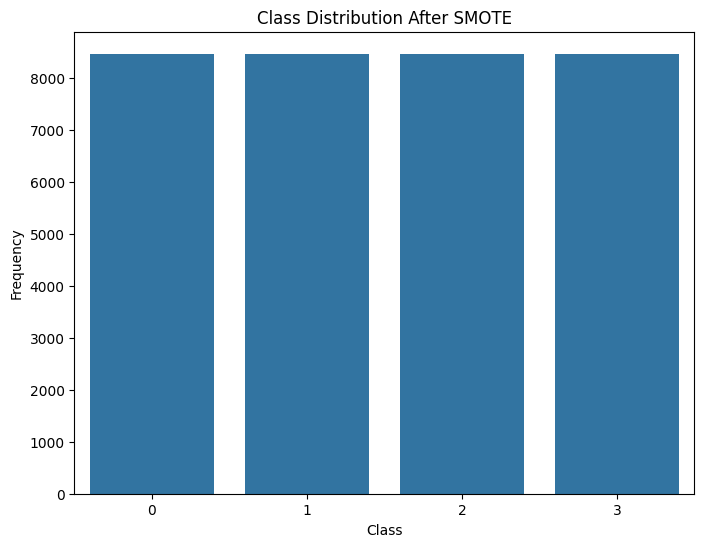

c:\Users\sagor\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
677/677 ━━━━━━━━━━━━━━━━━━━━ 134s 192ms/step - accuracy: 0.8924 - loss: 3.1560 - val_accuracy: 0.9647 - val_loss: 0.9104
Epoch 2/3
677/677 ━━━━━━━━━━━━━━━━━━━━ 124s 183ms/step - accuracy: 0.9354 - loss: 0.9068 - val_accuracy: 0.9586 - val_loss: 0.7744
Epoch 3/3
677/677 ━━━━━━━━━━━━━━━━━━━━ 123s 181ms/step - accuracy: 0.9403 - loss: 0.7601 - val_accuracy: 0.9701 - val_loss: 0.6278
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9682 - loss: 0.6367
Test Loss: 0.6306197643280029, Test Accuracy: 0.9685423374176025
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1692
           1       1.00      0.99      0.99      1672
           2       0.98      0.91      0.94      1722
           3       0.91      0.98      0.94      1685

    accuracy                           0.97      6771
   macro avg       0.97      0.97      0.97      6771
weighted avg       0.

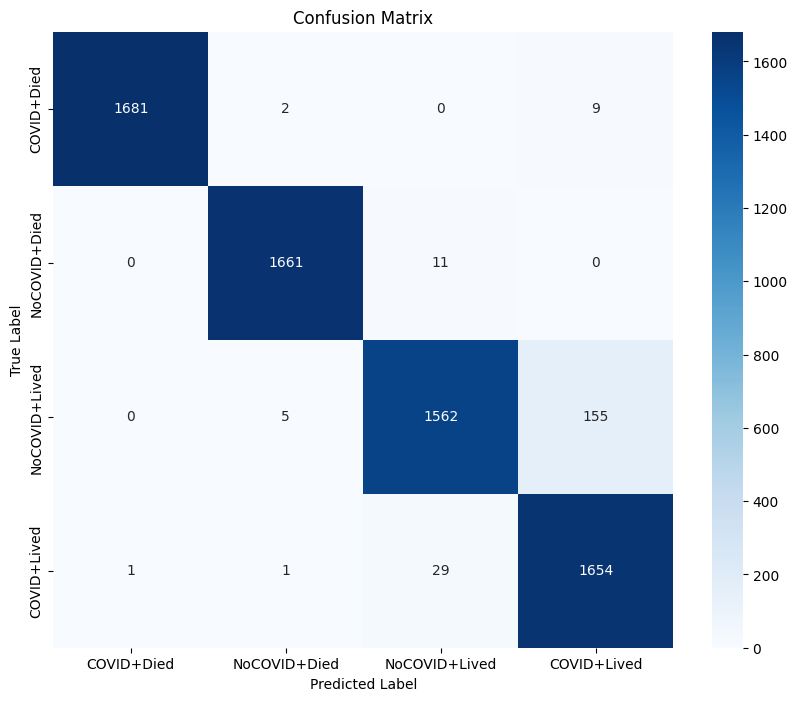

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Original Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        74
           1       0.99      0.99      0.99       387
           2       0.88      0.84      0.86       297
           3       0.97      0.98      0.98      1713

    accuracy                           0.97      2471
   macro avg       0.96      0.95      0.95      2471
weighted avg       0.97      0.97      0.97      2471



In [41]:

# Train and evaluate the model
trained_model = train_and_evaluate_model(merged_data)

In [ ]:
""" labels = create_labels(merged_data)
print(np.unique(labels, return_counts=True)) """

Label distribution: (array([0, 1, 2, 3]), array([  19, 2333, 3005, 6995]))
(array([0, 1, 2, 3]), array([  19, 2333, 3005, 6995]))


In [7]:
""" filtered_data = merged_data[["DECEASED_patients", "COVID-19_conditions"]].dropna()
print(f"Rows with valid labels: {len(filtered_data)}")
 """

Rows with valid labels: 11771
